In [42]:
import pandas
import re
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy
import matplotlib.pyplot as pyplot

#### Funciones

In [43]:
# Definir una función para convertir coordenadas en formato decimal a latitud y longitud
def convertir_coordenadas (coordenada):
    """Retorna el valor de la cordenada en base a su dirección

    Args:
        coordenada (String): Valor de la coordenada y su dirección

    Returns:
        int: Valor de la coordenada absoluto
    """
    valor = float(coordenada[:-2]) # Obtener el valor numérico de la coordenada
    direccion = coordenada[-1] # Obtener la dirección (N, S, E, W) de la coordenada
    if direccion in ['S', 'W']:
        valor = -valor # Si la dirección es sur o oeste, invertir el signo del valor
        
    return valor

In [44]:
def extraer_coordenadas(location):
    """Función que extrae las coordenadas de los sitios en peligro una location, ejemplo de coordenadas: `00.000°X 00.000°Y'`

    Args:
        location (String): Texto que contiene las coordenadas

    Returns:
        _type_: _description_
    """
    # Definir una expresión regular para buscar patrones de coordenadas en formato decimal
    patron = r"\b\d{1,3}\.\d{1,}°[NS]\b|\b\d{1,3}\.\d{1,}°[EW]\b"

    # Buscar patrones de coordenadas en formato decimal en el texto
    coordenadas = re.findall(patron, location)
    lat = convertir_coordenadas(coordenadas[0])
    lon = convertir_coordenadas(coordenadas[1])
    
    return pandas.Series({"Latitude": lat, "Longitude": lon})


In [45]:
url = "https://en.wikipedia.org/wiki/List_of_World_Heritage_in_Danger"
data = pandas.read_html(url)[1]

### Plano de Similitud

In [46]:
data[['Latitude', 'Longitude']] = data['Location'].apply(extraer_coordenadas)

# Agrupa los sitios por región
regions = data['Location'].str.split(', ').str[-1].value_counts().index.tolist()

# Crea un mapa centrado en la primera ubicación
mapa = folium.Map(location=[data.iloc[0]['Latitude'], data.iloc[0]['Longitude']], zoom_start=2)

# Agrega los sitios al mapa utilizando un marcador de clúster
marker_cluster = MarkerCluster().add_to(mapa)
for region in regions:
    group = data[data['Location'].str.contains(region)]
    for idx, row in group.iterrows():
        folium.Marker(location=[row['Latitude'], row['Longitude']], 
                      popup=row['Name'], 
                      icon=folium.Icon(color='red')).add_to(marker_cluster)

# Muestra el mapa
mapa


C:\Users\crist\AppData\Local\Temp\ipykernel_16124\4148475144.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  group = data[data['Location'].str.contains(region)]


### Circulo de Correlaciones

In [47]:
# Seleccionar variables
variables = ['Criteria', 'Endangered', 'Area ha (acre)', 'Reason']

# Transformar variables categóricas a numéricas
dummies = pandas.get_dummies(data[variables])

# Unir variables numéricas y el dataframe original
df_transformed = pandas.concat([data[['Latitude', 'Longitude']], dummies], axis=1)

# Nuevo DataFrame con las variables seleccionadas y eliminando las de varoles faltantes
df = df_transformed.dropna()

# Estandarizamos
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Aplicamos ACP/PCA y extraemos los componente principales
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)

# Creamos un nuevo DataFrame con los componentes principales
df_pcs = pandas.DataFrame(pcs, columns=['PC1', 'PC2'])

##### Grafico con puntos

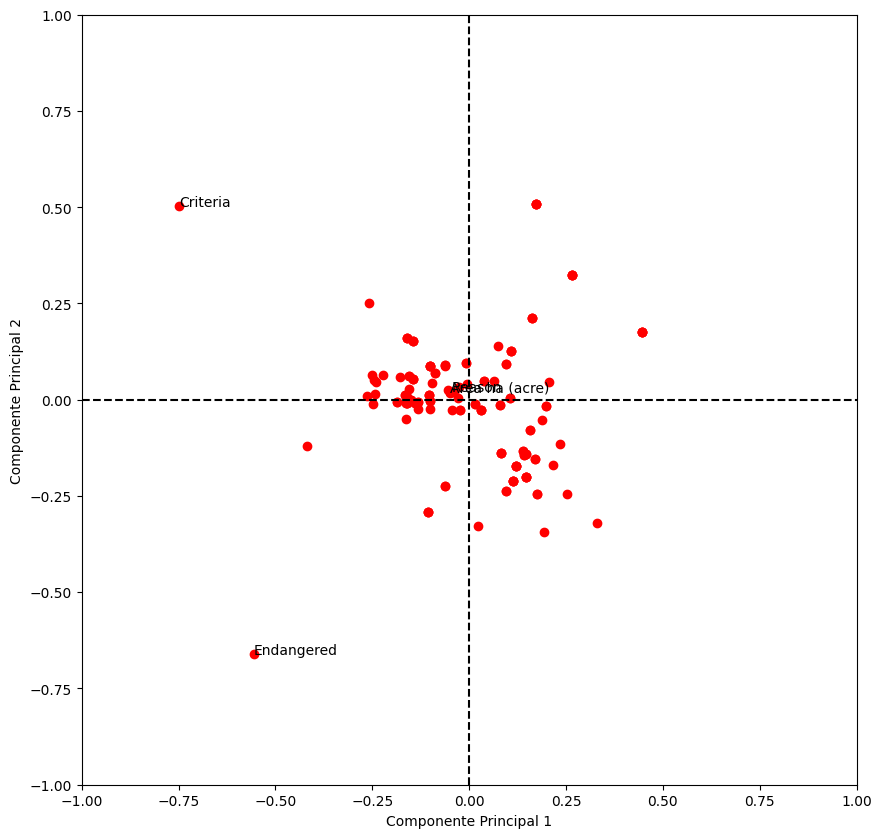

In [48]:
# Cálculo de los cosenos cuadrados de los componentes principales con las variables originales
loadings = pca.components_.T *  numpy.sqrt(pca.explained_variance_)

# Graficar el círculo de correlaciones
fig, ax = pyplot.subplots(figsize=(10,10))

for i, var in enumerate(variables):
    ax.annotate(var, (loadings[i, 0], loadings[i, 1]))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')

for i in range(loadings.shape[0]):
    ax.scatter(loadings[i, 0], loadings[i, 1], color='red')

pyplot.show()



##### Grafico con magnitudes

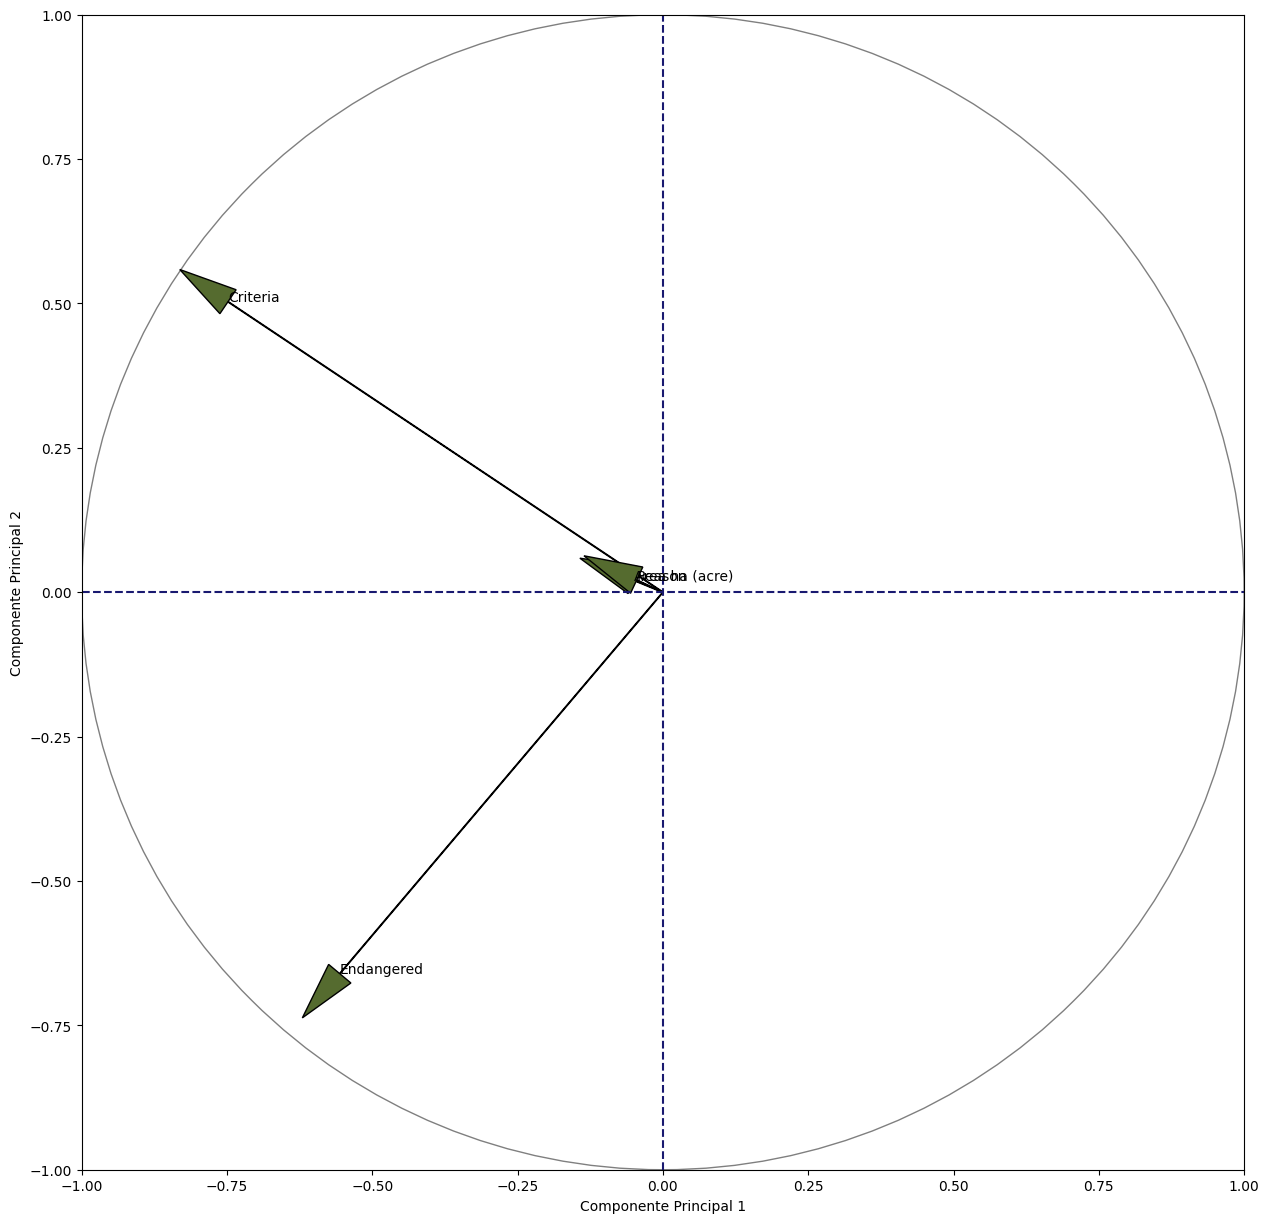

In [49]:
# Calcular los coeficientes de correlación
corr_matrix = numpy.corrcoef(X.T)
corrs = pca.components_.T * numpy.sqrt(pca.explained_variance_)

# Graficar el círculo de correlaciones
fig, ax = pyplot.subplots(figsize=(15,15))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.axhline(0, color='MidnightBlue', linestyle='--')
ax.axvline(0, color='MidnightBlue', linestyle='--')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')

# Etiquetar las variables originales
for i, v in enumerate(variables):
    ax.annotate(v, (corrs[i, 0], corrs[i, 1]))

# Graficar las flechas para los componentes principales
for i in range(len(variables)):
    ax.arrow(0, 0, corrs[i, 0], corrs[i, 1], head_width=0.05, head_length=0.1, fc='DarkOliveGreen', ec='Black')

# Agregamos un círculo alrededor del gráfico
circle = pyplot.Circle((0, 0), 1, facecolor='none', edgecolor='Black', alpha=0.5)
ax.add_artist(circle)

pyplot.show()

